(exithandler-workflow)=
# Running multiple functions with ExitHandler

This example uses the Kubernetes function ExitHandler to run multiple functions before continuing to the next function. 
The ExitHandler function is especially useful to do something that needs to be performed as the very last step; for example, sending an email or updating the run results of the previous steps somewhere else.

In [1]:
import mlrun

## Create the project and its functions

**Function D is designed to fail, to show the ExitHandler running after a failure.**

In [2]:
project = mlrun.get_or_create_project(
    "waiting-for-multiple-steps", "./", user_project=True
)

> 2024-04-16 09:28:55,586 [info] Project loaded successfully: {'project_name': 'waiting-for-multiple-steps'}


In [12]:
%%writefile funcs.py
import time

# First 3 functions to run
def func_A(context):
    time.sleep(5)
    context.logger.info(f"Function A is running now")
    return "Function A has been triggered"

def func_B(context):
    time.sleep(10)
    context.logger.info(f"Function B is running now")        
    return "Function B has been triggered"

def func_C(context):
    time.sleep(15)
    context.logger.info(f"Function C is running now")        
    return "Function C has been triggered"


# This function waits for the 3 functions to complete, then logs their results before raising an exception.
def func_D(context, func_a_res, func_b_res, func_c_res):
    context.logger.info(f"Function D is running now, logging the results of previous functions.")
    context.log_artifact("func_a_result", str(func_a_res))
    context.log_artifact("func_b_result", str(func_b_res))
    context.log_artifact("func_c_result", str(func_c_res))
    context.logger.info("Function D has been triggered")
    
    # Now it raises an Exception so the function fails.
    raise Exception("This is an example exception")

# This function will be part of the ExitHandler.
def func_final(context):
    context.logger.info(f"The final function is now running regardless of whether all preceding functions succeeded.")
    return "Function final has been triggered"

Overwriting funcs.py


In [13]:
# Set the functions in the project
func_A = project.set_function(
    func="funcs.py", name="func-A", handler="func_A", image="mlrun/mlrun", kind="job"
)
func_B = project.set_function(
    func="funcs.py", name="func-B", handler="func_B", image="mlrun/mlrun", kind="job"
)
func_C = project.set_function(
    func="funcs.py", name="func-C", handler="func_C", image="mlrun/mlrun", kind="job"
)
func_D = project.set_function(
    func="funcs.py", name="func-D", handler="func_D", image="mlrun/mlrun", kind="job"
)
func_final = project.set_function(
    func="funcs.py",
    name="func-final",
    handler="func_final",
    image="mlrun/mlrun",
    kind="job",
)

## Create the pipeline 

The ExitHandler function runs after the functions, A, B, C, D. 
It is triggered regardless of whether or not all of the preceding functions succeeded.

In [14]:
%%writefile workflow.py

from kfp import dsl
from mlrun.platforms import auto_mount
import os
import sys
import mlrun

@dsl.pipeline(name="ExitHandler and multiple wait pipeline", description="Pipeline that runs 3 functions simultaneously, waits for all of them to finish, and then runs another function that logs their results and fails. After all of this, an exit function is triggered.")
def kfpipeline(input_val):
    project = mlrun.get_current_project()
    
    # 'func_final' is executed after everything inside the block finishes or crashes.
    with dsl.ExitHandler(mlrun.run_function("func-final")):
        # Start 3 functions simultaneously
        step_1 = mlrun.run_function('func-A', returns=['first_func_res'])
        step_2 = mlrun.run_function('func-B', returns=['second_func_res'])
        step_3 = mlrun.run_function('func-C', returns=['third_func_res'])

        # Start the function only after the 3 first functions are done. This function logs the outputs of the previous functions as artifacts, and then crashes.
        step_4 = mlrun.run_function('func-D', params = {"func_a_res":step_1.outputs["first_func_res"],
                                                        "func_b_res":step_2.outputs["second_func_res"],
                                                        "func_c_res":step_3.outputs["third_func_res"]}, returns=["fourth_func_res"]).after(step_1, step_2, step_3)  


Overwriting workflow.py


In [15]:
project.set_workflow(name="workflow-func", workflow_path="workflow.py")
project.save()

## Run the workflow

Now run the workflow and check the workflow graph in the UI.

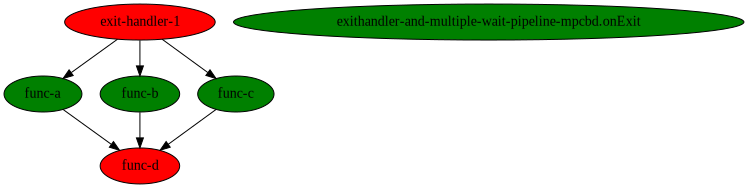

uid,start,state,name,parameters,results
...018654c6,Apr 16 09:35:45,completed,func-final,,return=Function final has been triggered
...52815485,Apr 16 09:35:18,error,func-d,func_a_res=Function A has been triggeredfunc_b_res=Function B has been triggeredfunc_c_res=Function C has been triggered,
...9fd65af4,Apr 16 09:34:39,completed,func-b,,second_func_res=Function B has been triggered
...045617ef,Apr 16 09:34:39,completed,func-c,,third_func_res=Function C has been triggered
...04882afb,Apr 16 09:34:39,completed,func-a,,first_func_res=Function A has been triggered


RuntimeError: Pipeline run status Failed

In [16]:
project.run(workflow_path="workflow.py", watch=True, local=False)

## Viewing the results in the UI Monitor Workflows tab

<img src="../_static/images/multi-step-workflow.png" width="800" >